## TODO
1. fill "null" in condition based on the manufacturing year
The easier way is to discard the data with null values.
2. How should we handle states?
Hard to do this part. We should remove states.
3. What metrics do we want to calculate model performance? (r2 score, accuracy)
I used r2 score, accuracy and mse to do the evaluation.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('cleaned_df_with_manufact.csv', keep_default_na=False)

In [3]:
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
0,13995,2012.0,ford,f-150,good,6 cylinders,gas,188406.0,automatic,4wd,truck,grey,mn
1,7995,2010.0,chevrolet,equinox,good,4 cylinders,gas,108124.0,automatic,4wd,SUV,grey,mn
2,8995,2011.0,chevrolet,traverse,good,6 cylinders,gas,178054.0,automatic,4wd,SUV,white,mn
3,10995,2014.0,ford,explorer,good,6 cylinders,gas,170259.0,automatic,4wd,SUV,white,mn
4,12995,2004.0,ram,2500,good,6 cylinders,diesel,309621.0,automatic,4wd,truck,custom,mn


In [4]:
for col in df.columns:
    print(col, "\t", len(df[df[col]=="null"]), "\t", len(df[col].unique()))

print("total samples: ", len(df))

price 	 0 	 7850
year 	 0 	 41
manufacturer 	 900 	 37
model 	 0 	 1520
condition 	 25416 	 7
cylinders 	 13387 	 9
fuel 	 0 	 5
odometer 	 0 	 45314
transmission 	 0 	 3
drive 	 0 	 3
type 	 0 	 13
paint_color 	 0 	 12
state 	 0 	 51
total samples:  83003


/Users/shane/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# Convert categorical features
------

In [5]:
# add all the columns you want to dummy/one hot
onehot_these_columns = []
delete_these_columns = []

## Model

In [6]:
len(df['model'].unique())
delete_these_columns.append('model')

## Manufacturer

In [7]:
df['manufacturer'].unique()

array(['ford', 'chevrolet', 'ram', 'buick', 'nissan', 'hyundai', 'dodge',
       'subaru', 'toyota', 'lexus', 'volvo', 'chrysler', 'jeep', 'acura',
       'gmc', 'kia', 'honda', 'volkswagen', 'bmw', 'null', 'pontiac',
       'cadillac', 'mazda', 'lincoln', 'saturn', 'fiat', 'audi',
       'mercury', 'mercedes-benz', 'mini', 'mitsubishi', 'jaguar',
       'infiniti', 'rover', 'tesla', 'land rover', 'alfa-romeo'],
      dtype=object)

In [8]:
price_buckets = {}
for k,v in dict(df.groupby("manufacturer")['price'].mean()).items():
    price_buckets[k] = int(v/5000)
print(price_buckets)

{'acura': 2, 'alfa-romeo': 5, 'audi': 2, 'bmw': 2, 'buick': 2, 'cadillac': 2, 'chevrolet': 2, 'chrysler': 1, 'dodge': 2, 'fiat': 1, 'ford': 3, 'gmc': 3, 'honda': 2, 'hyundai': 2, 'infiniti': 2, 'jaguar': 2, 'jeep': 3, 'kia': 2, 'land rover': 2, 'lexus': 2, 'lincoln': 2, 'mazda': 1, 'mercedes-benz': 3, 'mercury': 0, 'mini': 1, 'mitsubishi': 1, 'nissan': 2, 'null': 3, 'pontiac': 1, 'ram': 4, 'rover': 3, 'saturn': 0, 'subaru': 2, 'tesla': 7, 'toyota': 2, 'volkswagen': 2, 'volvo': 1}


In [9]:
# onehot_these_columns.append("manufacturer")
df['manufacturer'].replace(price_buckets, inplace=True)

In [10]:
df['manufacturer'].unique()

array([3, 2, 4, 1, 0, 7, 5])

## Condition

In [11]:
df['condition'].unique()

array(['good', 'fair', 'excellent', 'like new', 'null', 'new', 'salvage'],
      dtype=object)

In [12]:
df.groupby("condition")['price'].mean()

condition
excellent    12296.954851
fair          3464.130298
good         11390.026245
like new     15323.040108
new          16837.903030
null         17161.635623
salvage       5569.265306
Name: price, dtype: float64

/Users/shane/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/shane/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/shane/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/shane/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.

array([[<AxesSubplot:title={'center':'manufacturer'}>,
        <AxesSubplot:title={'center':'odometer'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'year'}>]], dtype=object)

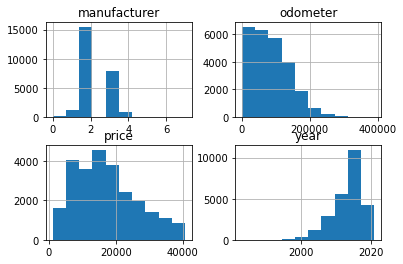

In [13]:
df[df['condition']=="null"].hist(bins=10)

In [14]:
onehot_these_columns.append("condition")

## Cylinders

In [15]:
df.groupby("cylinders")['price'].mean()

cylinders
10 cylinders    14549.672986
12 cylinders    10851.625000
3 cylinders     11303.132812
4 cylinders     10910.030387
5 cylinders      6950.400327
6 cylinders     13270.627364
8 cylinders     16473.431071
null            16542.824457
other           13574.572650
Name: price, dtype: float64

We have seen previously that most of the cylinders are either 4,6,8 or "null". Looking only at these categories, it seems that the trend is more the cylinders, higher the cost. So it might make sense to convert these categories to numbers instead of one-hot. There are very few cars with ['other',10,12,3,5] cyliners. We can convert the numbered categories to corresponding numbers and treat others as null.



**Other** *assign it the mean of all values* <br>
**null** *assign it the mean of all values*

<AxesSubplot:>

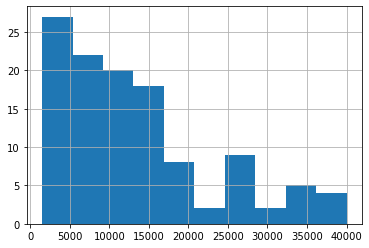

In [16]:
df[df['cylinders']=="other"]['price'].hist(bins=10)

In [17]:
mean_cylinder = (4+6+8)/3

replace_cylinders = {'3 cylinders':3, '4 cylinders':4, '5 cylinders':5, 
           '6 cylinders':6, '8 cylinders':8, '10 cylinders':10, 
           '12 cylinders':12, 'null':mean_cylinder, 'other':mean_cylinder}

df['cylinders'].replace(replace_cylinders, inplace=True)

In [18]:
df['cylinders'].unique()

array([ 6.,  4.,  8.,  5.,  3., 10., 12.])

## Fuel

In [19]:
df.groupby("fuel")['price'].agg([('mean'),('count')])

,mean,count
fuel,,
diesel,20854.858158,3941
electric,15166.683908,174
gas,13025.972290,75784
hybrid,11242.358569,1202
other,19159.013670,1902


Since there are only 5 categories, we can convert this column to dummy (onehot).

In [20]:
onehot_these_columns.append('fuel')

## Transmission

In [21]:
df.groupby("transmission")['price'].agg([('mean'),('count')])

,mean,count
transmission,,
automatic,13406.896059,74927
manual,10966.174769,4875
other,19976.082162,3201


Since there are only 3 unique values, we should convert this to dummy(onehot).

In [22]:
onehot_these_columns.append('transmission')

## Drive

In [23]:
df.groupby("drive")['price'].agg([('mean'),('count')])

,mean,count
drive,,
4wd,16590.406614,31841
fwd,10372.548913,38037
rwd,15173.048533,13125


Since there are only 3 unique values, we should convert this to dummy(onehot).

In [24]:
onehot_these_columns.append('drive')

## Type

In [25]:
df.groupby("type")['price'].agg([('mean'),('count')])

,mean,count
type,,
SUV,13817.498382,23799
bus,18051.030303,33
convertible,12887.358553,1520
coupe,15030.873151,3989
hatchback,8957.641141,3330
mini-van,9352.472274,2164
offroad,14647.139665,179
other,17443.189781,1644
pickup,20043.934753,7418


Since the price does fluctuate with the type of vehicle, this feature seems useful. Let's convert this to a dummy (onehot) as well.

In [26]:
onehot_these_columns.append('type')

## Paint

In [27]:
df.groupby("paint_color")['price'].agg([('mean'),('count')])

,mean,count
paint_color,,
black,14574.167654,15860
blue,11694.343485,8833
brown,10781.580084,1898
custom,14022.346578,3171
green,9246.564463,2133
grey,12753.835218,9376
orange,16363.644211,475
purple,9380.276151,239
red,12791.435066,8139


It looks like some colors are preferred over the others. Let's also convert this column to dummy(onehot).

In [28]:
delete_these_columns.append('paint_color')

## State

In [29]:
df.groupby("state")['price'].agg([('mean'),('count')])

,mean,count
state,,
ak,18272.636199,1105
al,14327.241065,1427
ar,14580.399110,674
az,12604.070473,1121
ca,14843.310898,6359
co,14102.405543,2562
ct,12361.484975,1198
dc,10564.535354,594
de,12961.556420,257


The prices of the used cars vary from one state to another. But it is hard to tell if it will play an important role in building the model for now.

In [30]:
delete_these_columns.append('state')

## Year

In [31]:
df['year'].describe()

count    83003.000000
mean      2011.128610
std          5.800385
min       1981.000000
25%       2007.000000
50%       2012.000000
75%       2016.000000
max       2021.000000
Name: year, dtype: float64

In [32]:
df['year_count'] = df['year']-1980
delete_these_columns.append('year')

<AxesSubplot:xlabel='year'>

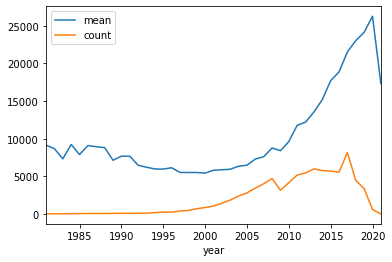

In [33]:
df.groupby('year')['price'].agg([('mean'),('count')]).plot()

## Correlations

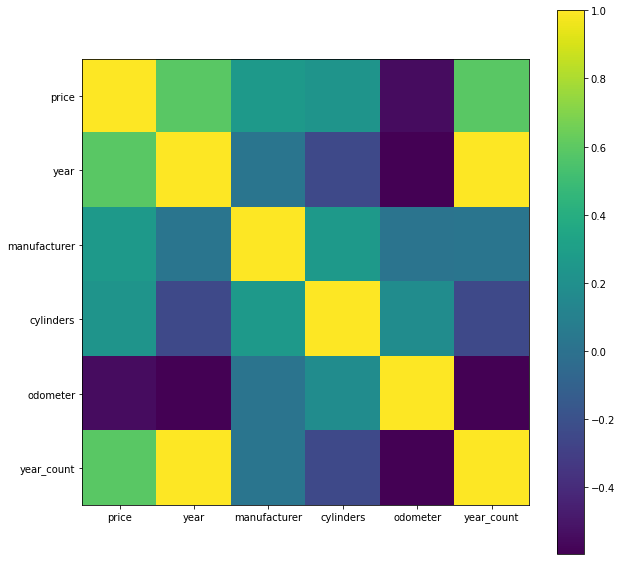

In [34]:
corr_matrix= df.corr()
fig_cor, axes_cor = plt.subplots(1,1)
fig_cor.set_size_inches(10, 10)

labels = df.select_dtypes(include=np.number).columns.tolist()

myimage = axes_cor.imshow(corr_matrix)

plt.colorbar(myimage)

axes_cor.set_xticks(np.arange(0,corr_matrix.shape[0], corr_matrix.shape[0]*1.0/len(labels)))
axes_cor.set_yticks(np.arange(0,corr_matrix.shape[1], corr_matrix.shape[1]*1.0/len(labels)))

axes_cor.set_xticklabels(labels)
axes_cor.set_yticklabels(labels)

plt.draw()

## Convert to onehot/dummy

In [35]:
print("We want to convert these columns into onehot:\n", onehot_these_columns)


We want to convert these columns into onehot:
 ['condition', 'fuel', 'transmission', 'drive', 'type']


In [36]:
df_dummy = pd.get_dummies(df, columns=onehot_these_columns)

## Drop columns

In [37]:
df_dummy.drop(columns=delete_these_columns, axis=1, inplace=True)

In [38]:
df_dummy.head()

,price,manufacturer,cylinders,odometer,year_count,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,13995,3,6.0,188406.0,32.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,7995,2,4.0,108124.0,30.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8995,2,6.0,178054.0,31.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10995,3,6.0,170259.0,34.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12995,4,6.0,309621.0,24.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [39]:
df_dummy.dtypes

price                       int64
manufacturer                int64
cylinders                 float64
odometer                  float64
year_count                float64
condition_excellent         uint8
condition_fair              uint8
condition_good              uint8
condition_like new          uint8
condition_new               uint8
condition_null              uint8
condition_salvage           uint8
fuel_diesel                 uint8
fuel_electric               uint8
fuel_gas                    uint8
fuel_hybrid                 uint8
fuel_other                  uint8
transmission_automatic      uint8
transmission_manual         uint8
transmission_other          uint8
drive_4wd                   uint8
drive_fwd                   uint8
drive_rwd                   uint8
type_SUV                    uint8
type_bus                    uint8
type_convertible            uint8
type_coupe                  uint8
type_hatchback              uint8
type_mini-van               uint8
type_offroad  

## Insight of the Price

In [40]:
df_dummy['price'].value_counts()

6995     923
7995     895
8995     844
3500     817
5995     776
4500     774
9995     766
6500     726
5500     725
10995    697
2500     625
7500     614
4995     608
12995    606
14995    584
11995    581
5000     573
13995    561
8500     514
3000     502
4000     480
15995    462
3995     457
16995    456
6000     440
9500     429
19995    422
2000     418
12500    415
7000     410
        ... 
26600      1
28649      1
20461      1
10272      1
8225       1
18476      1
8289       1
9824       1
15907      1
39799      1
13602      1
35765      1
19501      1
23663      1
33908      1
35957      1
25768      1
19629      1
29930      1
15651      1
19949      1
34100      1
19821      1
15779      1
21934      1
11745      1
13794      1
30186      1
32235      1
18441      1
Name: price, Length: 7850, dtype: int64

In [41]:
print(df_dummy['price'].max())
print(df_dummy['price'].min())

40712
1050


-----
# Model
-----

In [42]:
model_results = dict()
model_names = ['Linear Regression', 'Extra Trees Regression', 
               'Bagging Regression', 'Ridge Regression', 'AdaBoost Regression', 
               'Decision Tree Regression']

In [43]:
y = df_dummy['price']
X = df_dummy.drop(columns=['price'])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, shuffle=True)

In [45]:
len(X_train), len(X_test)

(74702, 8301)

In [46]:
def loss_MSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5


# find whether our prediction is correct within a certain threshold
def accuracy(y_true, y_pred, thresh=100):
    return np.sum(np.where(abs(y_true-y_pred)<thresh, 1, 0)) / len(y_true)

def acc_r2(y_true, y_pred):
    return round(r2_score(y_true, y_pred) * 100, 2)

def printResults(model, y_train, y_test, y_pred_train, y_pred_test, threshold):
    mse_train = loss_MSE(y_train, y_pred_train)
    mse_test = loss_MSE(y_test, y_pred_test)
    acc_train = accuracy(y_train, y_pred_train, threshold)
    acc_test = accuracy(y_test, y_pred_test, threshold)
    r2_train = acc_r2(y_train, y_pred_train)
    r2_test = acc_r2(y_test, y_pred_test)
    # save results
    model_results[model] = [mse_train, mse_test, acc_train, acc_test, r2_train, r2_test]
    print("Loss MSE(Train): ", mse_train)
    print("Loss MSE(Test): ", mse_test)
    print("Accuracy with threshold =", threshold, "(Train):", acc_train)
    print("Accuracy with threshold =", threshold, "(Test):", acc_test)
    print("R2 Score(Train): ", r2_train)
    print("R2 Score(Test): ", r2_test)

In [47]:
threshold = 2000

### Linear Regression

In [48]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [49]:
y_pred_train = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)
printResults(model_names[0], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  4783.264646427145
Loss MSE(Test):  4772.13863856898
Accuracy with threshold = 2000 (Train): 0.37102085620197583
Accuracy with threshold = 2000 (Test): 0.37609926514877723
R2 Score(Train):  71.63
R2 Score(Test):  71.12


### Extra Trees Regression

In [50]:
model_etr = ExtraTreesRegressor()
model_etr.fit(X_train, y_train)

ExtraTreesRegressor()

In [51]:
y_pred_train = model_etr.predict(X_train)
y_pred_test = model_etr.predict(X_test)
printResults(model_names[1], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  279.5790616683741
Loss MSE(Test):  3669.2525730188163
Accuracy with threshold = 2000 (Train): 0.99649273111831
Accuracy with threshold = 2000 (Test): 0.6104083845319841
R2 Score(Train):  99.9
R2 Score(Test):  82.93


### Bagging Regression

In [52]:
model_bagging = BaggingRegressor()
model_bagging.fit(X_train, y_train)

BaggingRegressor()

In [53]:
y_pred_train = model_bagging.predict(X_train)
y_pred_test = model_bagging.predict(X_test)
printResults(model_names[2], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  1537.0969144801593
Loss MSE(Test):  3590.5702096196965
Accuracy with threshold = 2000 (Train): 0.8664158924794517
Accuracy with threshold = 2000 (Test): 0.5896879893988676
R2 Score(Train):  97.07
R2 Score(Test):  83.65


### Ridge Regression

In [54]:
model_rcv = RidgeCV()
model_rcv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [55]:
y_pred_train = model_rcv.predict(X_train)
y_pred_test = model_rcv.predict(X_test)
printResults(model_names[3], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  4783.71804028512
Loss MSE(Test):  4773.1203770752945
Accuracy with threshold = 2000 (Train): 0.3705657144387031
Accuracy with threshold = 2000 (Test): 0.3774244066979882
R2 Score(Train):  71.63
R2 Score(Test):  71.11


### AdaBoost Regression

In [56]:
model_adaboost = AdaBoostRegressor()
model_adaboost.fit(X_train, y_train)

AdaBoostRegressor()

In [57]:
y_pred_train = model_adaboost.predict(X_train)
y_pred_test = model_adaboost.predict(X_test)
printResults(model_names[4], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  5328.234068980364
Loss MSE(Test):  5315.306356725578
Accuracy with threshold = 2000 (Train): 0.23430430242831518
Accuracy with threshold = 2000 (Test): 0.24527165401758824
R2 Score(Train):  64.8
R2 Score(Test):  64.17


### Decision Tree Regression

In [58]:
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [59]:
y_pred_train = model_dt.predict(X_train)
y_pred_test = model_dt.predict(X_test)
printResults(model_names[5], y_train, y_test, y_pred_train, y_pred_test, threshold)

Loss MSE(Train):  279.13551237335696
Loss MSE(Test):  4534.738817575615
Accuracy with threshold = 2000 (Train): 0.9965061176407592
Accuracy with threshold = 2000 (Test): 0.5464401879291652
R2 Score(Train):  99.9
R2 Score(Test):  73.92


## Comparison of models

In [60]:
mse_train = []
mse_test = []
acc_train = []
acc_test = []
r2_train = []
r2_test = []

for name in model_names:
    res = model_results[name]
    mse_train.append(res[0])
    mse_test.append(res[1])
    acc_train.append(res[2])
    acc_test.append(res[3])
    r2_train.append(res[4])
    r2_test.append(res[5])
    
models = pd.DataFrame({
    'model': model_names,
    'mse_train': mse_train,
    'mse_test': mse_test,
    'acc_train': acc_train,
    'acc_test': acc_test,
    'r2_train': r2_train,
    'r2_test': r2_test
                     })

### Mean Square Error

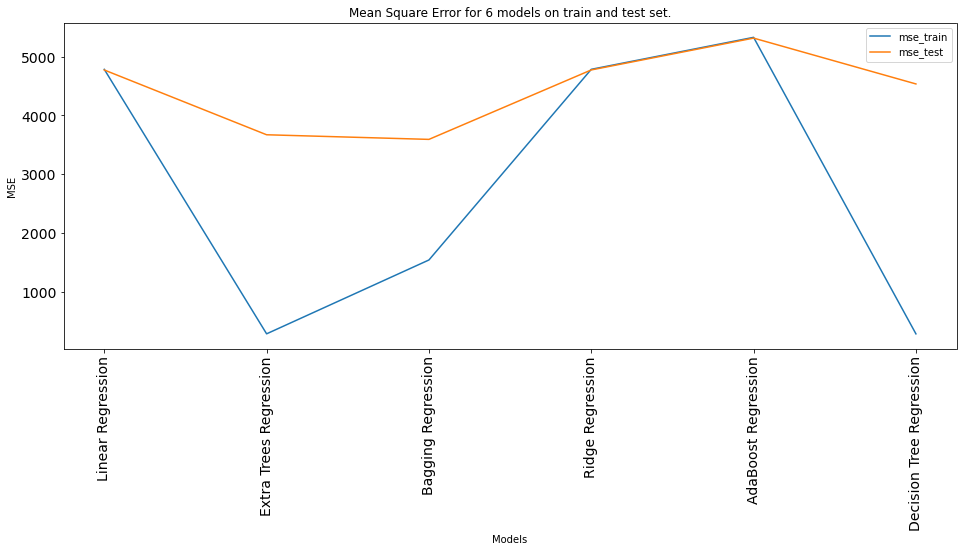

In [61]:
plt.figure(figsize=[16,6])
xx = models['model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['mse_train'], label = 'mse_train')
plt.plot(xx, models['mse_test'], label = 'mse_test')
plt.legend()
plt.title('Mean Square Error for 6 models on train and test set.')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(xx, rotation='vertical')
plt.show()

### Accuracy with threshold

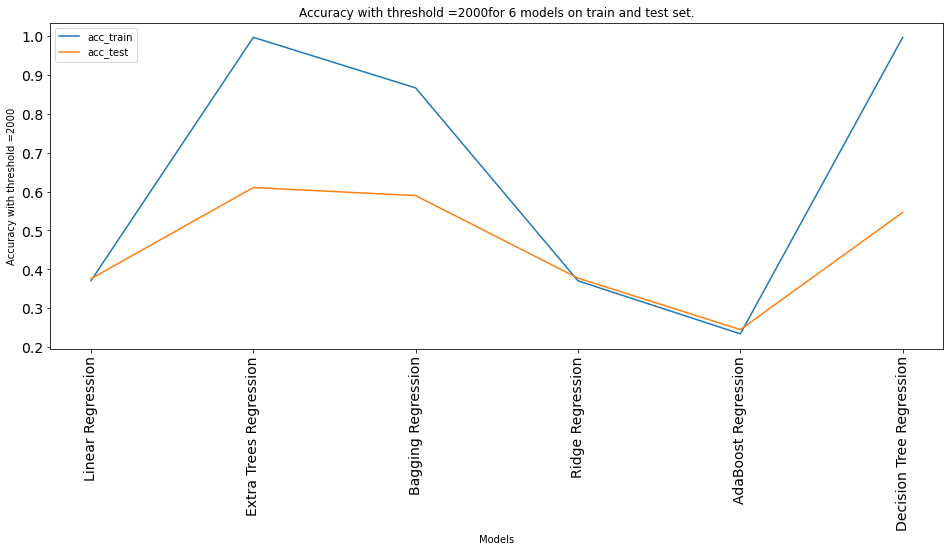

In [62]:
plt.figure(figsize=[16,6])
xx = models['model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['acc_train'], label = 'acc_train')
plt.plot(xx, models['acc_test'], label = 'acc_test')
plt.legend()
plt.title('Accuracy with threshold ='+str(threshold)+'for 6 models on train and test set.')
plt.xlabel('Models')
plt.ylabel('Accuracy with threshold ='+str(threshold))
plt.xticks(xx, rotation='vertical')
plt.show()

### R2 Score

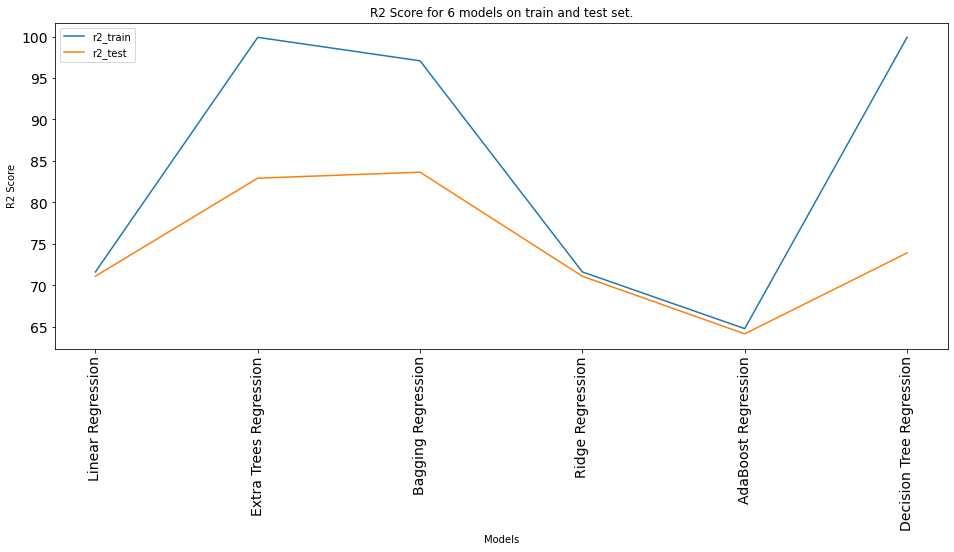

In [63]:
plt.figure(figsize=[16,6])
xx = models['model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2 Score for 6 models on train and test set.')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.xticks(xx, rotation='vertical')
plt.show()

# Prediction

From the results of the last section, we conclude that the Extra Trees Regression performs the best among the regression models.
So in this part, we will choose to use it to perform the prediction.

In [64]:
used_car = pd.DataFrame().reindex_like(X_test)[:1]
used_car['manufacturer'] = "honda"
used_car['manufacturer'].replace(price_buckets, inplace=True)
used_car['cylinders'] = 12.0
used_car['odometer'] = 100000.0
used_car['year_count'] = 2010-1980
used_car['condition_excellent'] = 1
used_car['condition_fair'] = 0
used_car['condition_good'] = 0
used_car['condition_like new'] = 0
used_car['condition_new'] = 0
used_car['condition_null'] = 0
used_car['condition_salvage'] = 0
used_car['fuel_diesel'] = 0
used_car['fuel_electric'] = 0
used_car['fuel_gas'] = 1
used_car['fuel_hybrid'] = 0
used_car['fuel_other'] = 0
used_car['transmission_automatic'] = 1
used_car['transmission_manual'] = 0
used_car['transmission_other'] = 0
used_car['drive_4wd'] = 0
used_car['drive_fwd'] = 1
used_car['drive_rwd'] = 0
used_car['type_SUV'] = 0
used_car['type_bus'] = 0
used_car['type_convertible'] = 0
used_car['type_coupe'] = 0
used_car['type_hatchback'] = 0
used_car['type_mini-van'] = 0
used_car['type_offroad'] = 0
used_car['type_other'] = 0
used_car['type_pickup'] = 0
used_car['type_sedan'] = 1
used_car['type_truck'] = 0
used_car['type_van'] = 0
used_car['type_wagon'] = 0

y_pred_test = model_etr.predict(used_car)
print("Car's value:", y_pred_test)

Car's value: [8205.1]
